### Importing Required Libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# Set plot style for better visuals
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


### Load the Dataset

In [ ]:
try:
    df = pd.read_csv('diabetes_prediction_dataset.csv')
    print("✅ Dataset loaded successfully!")
except FileNotFoundError:
    print("❌ File not found! Make sure 'diabetes_prediction_dataset.csv' is in your directory.")

# View first 5 rows
df.head()


✅ Dataset loaded successfully!


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


###  Inspect the Dataset


In [ ]:
# Check data types and non-null counts
df.info()

# Quick stats for numerical columns
print(df.describe())

# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Drop duplicate rows if any
df.drop_duplicates(inplace=True)
print(f"Remaining rows after dropping duplicates: {df.shape[0]}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.636783

### Visualize Target Distribution

/tmp/ipython-input-4-880841390.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='diabetes', data=df, palette='viridis')


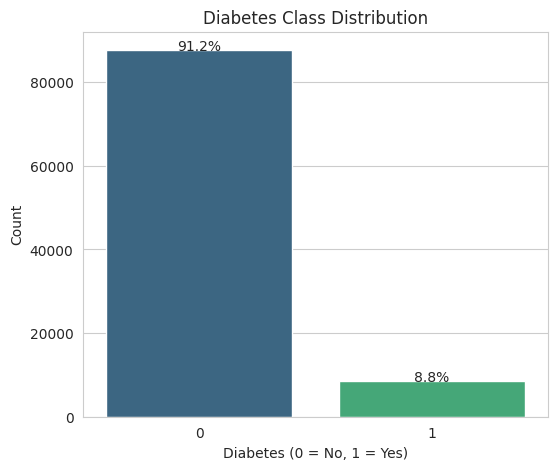

diabetes
0    87664
1     8482
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(6, 5))
sns.countplot(x='diabetes', data=df, palette='viridis')
plt.title('Diabetes Class Distribution')
plt.xlabel('Diabetes (0 = No, 1 = Yes)')
plt.ylabel('Count')

# Add percentage labels
total = len(df)
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 5, f'{height/total:.1%}', ha="center")

plt.show()

# Print actual counts
print(df['diabetes'].value_counts())


### Visualize Key Numerical Features

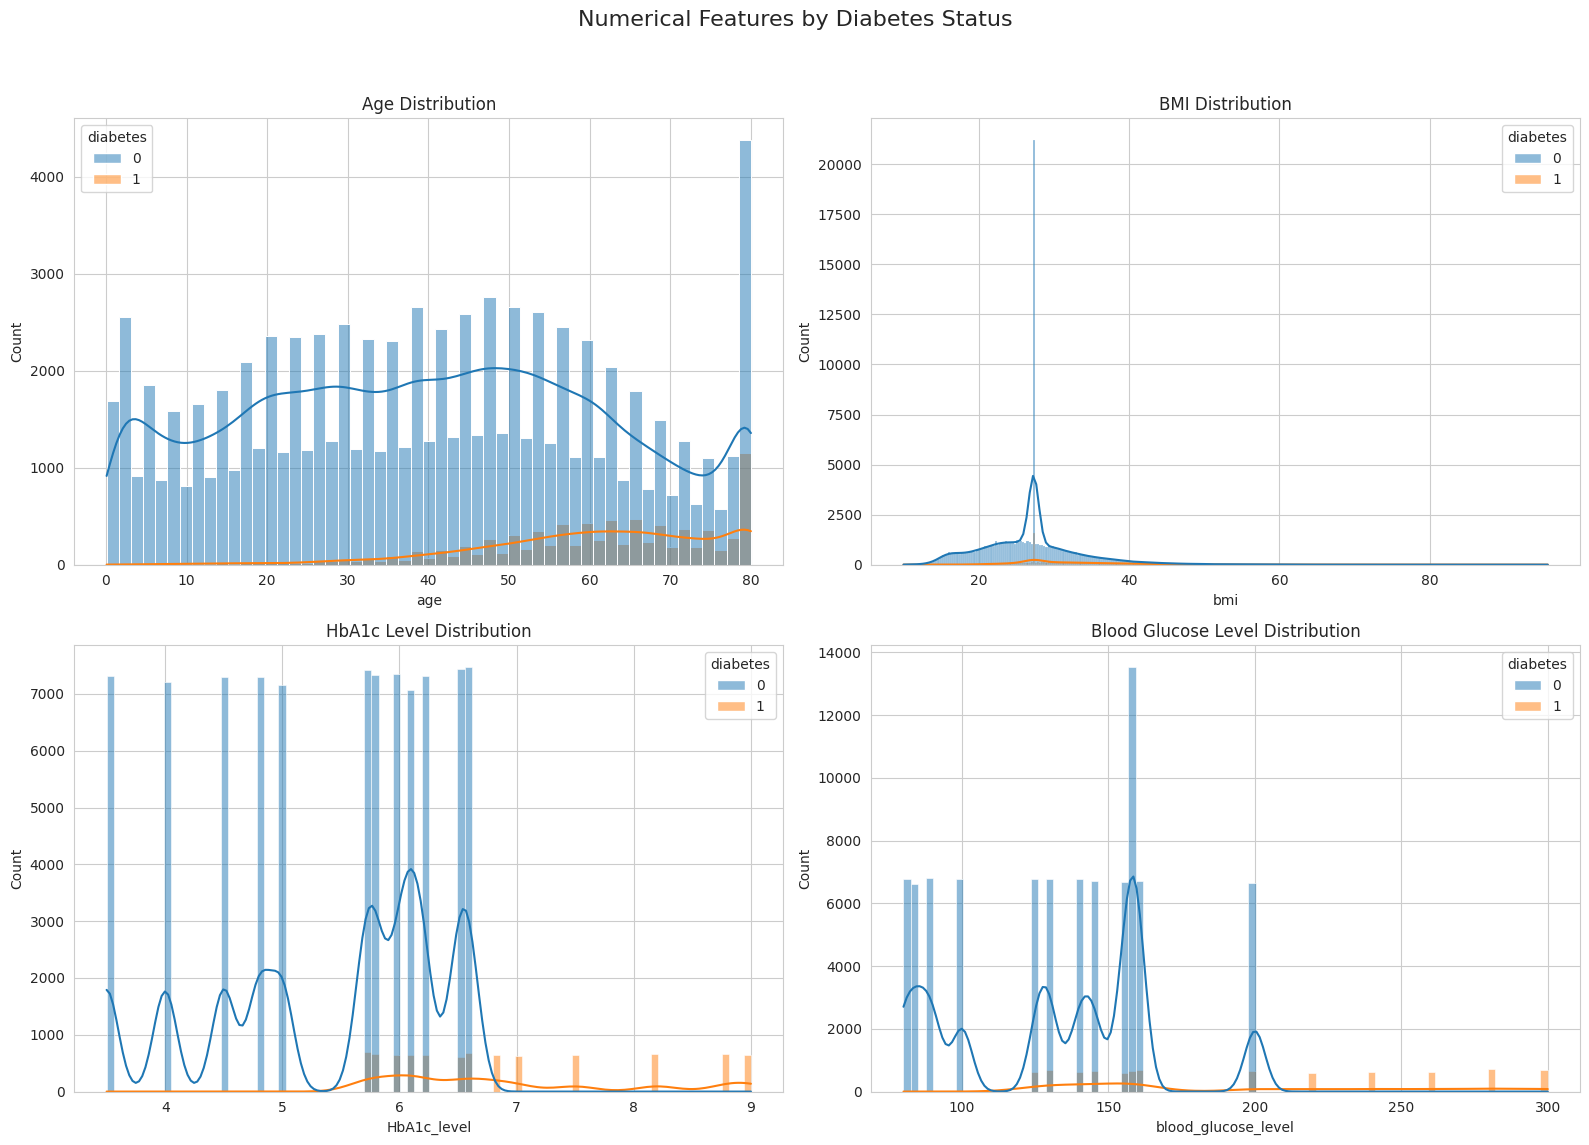

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Numerical Features by Diabetes Status', fontsize=16)

# Age
sns.histplot(data=df, x='age', hue='diabetes', kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution')

# BMI
sns.histplot(data=df, x='bmi', hue='diabetes', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('BMI Distribution')

# HbA1c Level
sns.histplot(data=df, x='HbA1c_level', hue='diabetes', kde=True, ax=axes[1, 0])
axes[1, 0].set_title('HbA1c Level Distribution')

# Blood Glucose Level
sns.histplot(data=df, x='blood_glucose_level', hue='diabetes', kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Blood Glucose Level Distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Data Preparation & Split

In [ ]:
# Inspect gender values
print(df['gender'].value_counts())

# Remove rare 'Other' gender rows
df = df[df['gender'] != 'Other']

# Separate features (X) and target (y)
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Identify column types
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# Split into training & testing (80/20), stratify to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")


gender
Female    56161
Male      39967
Other        18
Name: count, dtype: int64
Numerical features: ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
Categorical features: ['gender', 'smoking_history']
Training shape: (76902, 8)
Testing shape: (19226, 8)


### Create Preprocessing Transformers

In [ ]:
# Scale numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Encode categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)


### Train and Evaluate Multiple Models


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17530
           1       0.86      0.64      0.73      1696

    accuracy                           0.96     19226
   macro avg       0.91      0.81      0.86     19226
weighted avg       0.96      0.96      0.96     19226



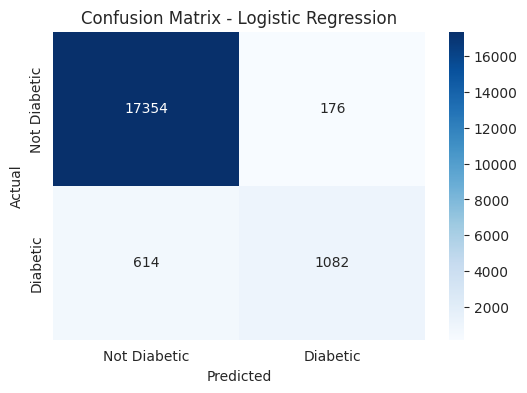


--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     17530
           1       0.72      0.75      0.73      1696

    accuracy                           0.95     19226
   macro avg       0.85      0.86      0.85     19226
weighted avg       0.95      0.95      0.95     19226



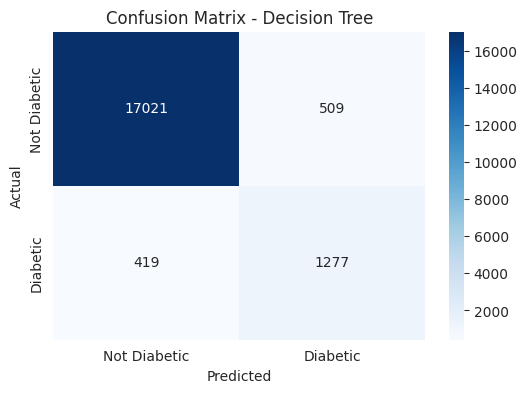


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17530
           1       0.94      0.70      0.80      1696

    accuracy                           0.97     19226
   macro avg       0.95      0.85      0.89     19226
weighted avg       0.97      0.97      0.97     19226



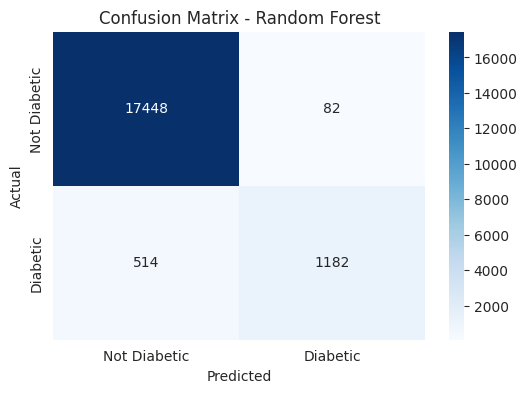

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:01:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17530
           1       0.95      0.70      0.81      1696

    accuracy                           0.97     19226
   macro avg       0.96      0.85      0.90     19226
weighted avg       0.97      0.97      0.97     19226



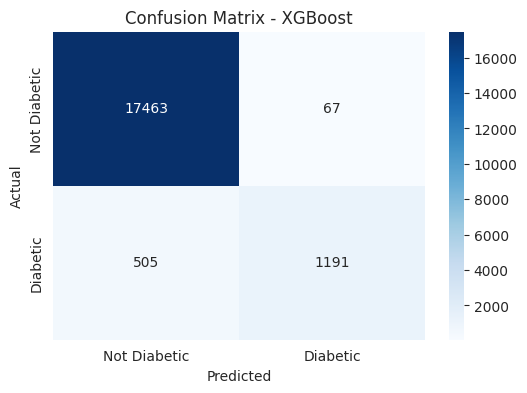

In [ ]:
# Models to test
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Store metrics
results = {}

# Loop through models
for name, model in models.items():
    # Full pipeline: preprocessing + model
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Fit on training data
    model_pipeline.fit(X_train, y_train)

    # Predict on test set
    y_pred = model_pipeline.predict(X_test)
    y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    }

    # Print classification report
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))

    # Confusion matrix heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Diabetic', 'Diabetic'],
                yticklabels=['Not Diabetic', 'Diabetic'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


### Compare All Model Results

                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
XGBoost              0.970249   0.946741  0.702241  0.806364  0.976194
Random Forest        0.969000   0.935127  0.696934  0.798649  0.954820
Decision Tree        0.951732   0.715006  0.752948  0.733487  0.862674
Logistic Regression  0.958910   0.860095  0.637972  0.732566  0.959565


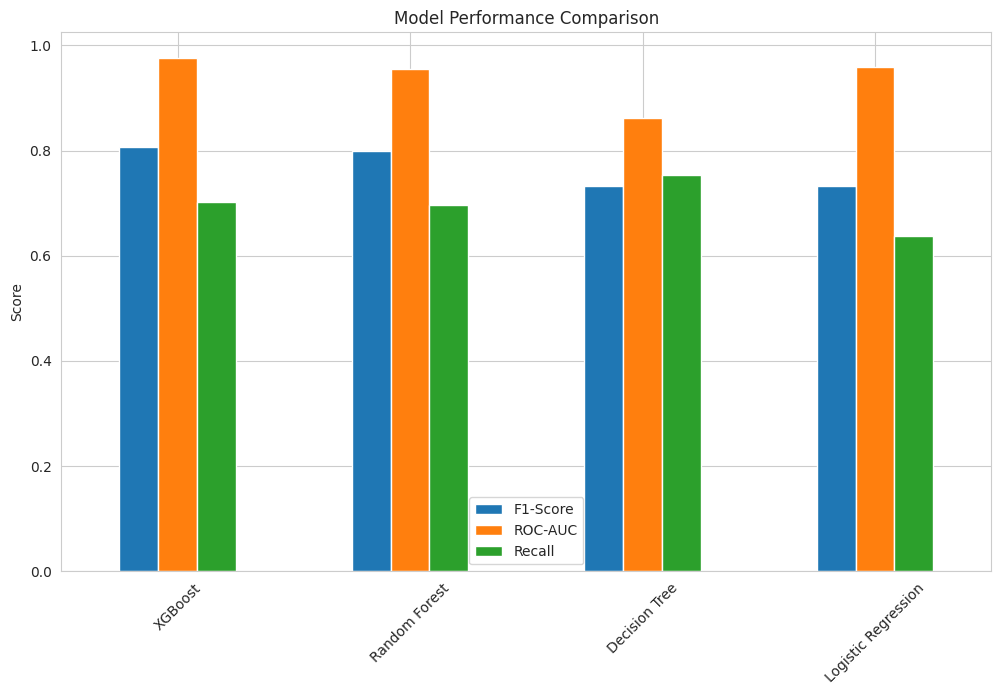

In [ ]:
# Convert to DataFrame
results_df = pd.DataFrame(results).T.sort_values(by="F1-Score", ascending=False)
print(results_df)

# Plot comparison
results_df[['F1-Score', 'ROC-AUC', 'Recall']].plot(
    kind='bar',
    figsize=(12, 7),
    title='Model Performance Comparison'
)
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()


### Test Impact of Data Size

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:01:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:01:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:01:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model          Logistic Regression   XGBoost
Training Size                               
30%                       0.727704  0.797068
60%                       0.730964  0.803650
100%                      0.732566  0.806364


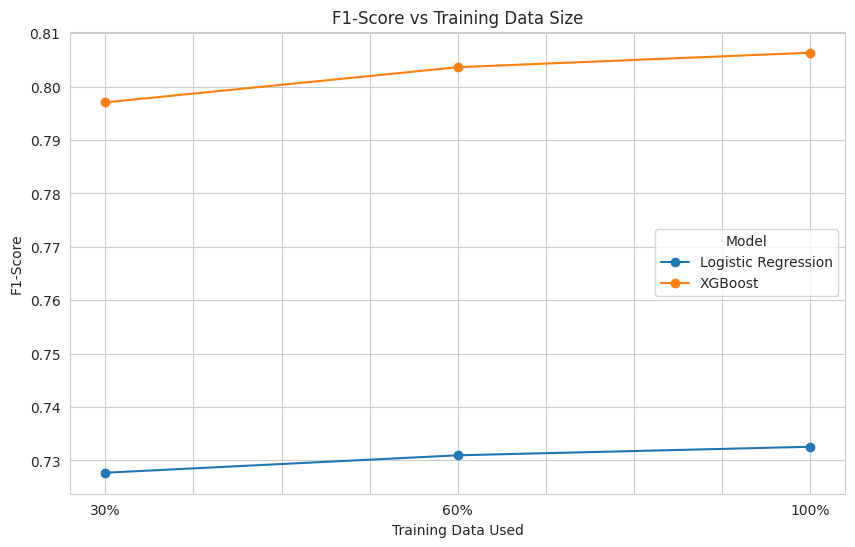

In [ ]:
train_sizes = [0.3, 0.6, 1.0]
results_data_size = []

# Compare simple vs complex model
models_to_test = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Loop through sizes
for name, model in models_to_test.items():
    for size in train_sizes:
        subset_size = int(size * len(X_train))
        X_train_subset = X_train[:subset_size]
        y_train_subset = y_train[:subset_size]

        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
        pipeline.fit(X_train_subset, y_train_subset)

        y_pred = pipeline.predict(X_test)
        f1 = f1_score(y_test, y_pred)

        results_data_size.append({
            "Model": name,
            "Training Size": f"{int(size*100)}%",
            "F1-Score": f1
        })

# Create pivot table
data_size_df = pd.DataFrame(results_data_size)
pivot_df = data_size_df.pivot(index='Training Size', columns='Model', values='F1-Score').reindex([f"{int(s*100)}%" for s in train_sizes])

print(pivot_df)

# Plot results
pivot_df.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('F1-Score vs Training Data Size')
plt.ylabel('F1-Score')
plt.xlabel('Training Data Used')
plt.grid(True)
plt.show()


### XGBoost performed best!

### Overfitting/Underfitting Check

In [ ]:
# Logistic Regression
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(solver='liblinear'))])
lr_pipeline.fit(X_train, y_train)
train_acc_lr = accuracy_score(y_train, lr_pipeline.predict(X_train))
test_acc_lr = accuracy_score(y_test, lr_pipeline.predict(X_test))

# Random Forest
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=42))])
rf_pipeline.fit(X_train, y_train)
train_acc_rf = accuracy_score(y_train, rf_pipeline.predict(X_train))
test_acc_rf = accuracy_score(y_test, rf_pipeline.predict(X_test))

print("--- Overfitting Analysis ---")
print(f"Logistic Regression | Train Acc: {train_acc_lr:.4f} | Test Acc: {test_acc_lr:.4f}")
print(f"Random Forest       | Train Acc: {train_acc_rf:.4f} | Test Acc: {test_acc_rf:.4f}")


--- Overfitting Analysis ---
Logistic Regression | Train Acc: 0.9588 | Test Acc: 0.9589
Random Forest       | Train Acc: 0.9992 | Test Acc: 0.9690
